In [ ]:
# Unzip the uploaded file
zip_path = '/content/color.zip'
extract_path = '/content/data/images'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# List the contents of the extracted folder
extracted_files = os.listdir(extract_path)
extracted_files

NameError: name 'zipfile' is not defined

In [ ]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image

# Step 1: Unzip the image files
with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/color.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data/images')

# Step 2: Load and preprocess the data
class ImageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, str(self.data_frame.iloc[idx, 0]))
        image = Image.open(img_name).convert('RGB')
        labels = self.data_frame.iloc[idx, 1:].values.astype('float')

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(labels)

# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load the dataset
dataset = ImageDataset(csv_file='/content/label.csv', root_dir='/content/data/images/color', transform=None)

# Step 3: Split the data into training and testing sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Apply transformations to the datasets
train_dataset.dataset.transform = train_transform
test_dataset.dataset.transform = test_transform

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Define the ResNet model
class ResNetRegressor(nn.Module):
    def __init__(self):
        super(ResNetRegressor, self).__init__()
        self.resnet = models.resnet50(pretrained=True)

        # Freeze all layers
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Replace the final fully connected layer
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 16)  # 16 output values

        # Unfreeze the final fully connected layer
        for param in self.resnet.fc.parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.resnet(x)


# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = ResNetRegressor().to(device).float()  # Move model to GPU and ensure model parameters are in float
criterion = nn.MSELoss().to(device).float()  # Move loss function to GPU and ensure it is in float
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Add a callback to stop training if the test loss goes below 35
class EarlyStoppingCallback(object):
    def __init__(self, patience=3, target_loss=40.0):
        self.patience = patience
        self.target_loss = target_loss
        self.best_loss = None
        self.no_improvement_count = 0

    def __call__(self, epoch, test_loss):
        if test_loss < self.target_loss:
            print(f"Target test loss achieved at epoch {epoch+1}. Stopping training.")
            return True
        return False

early_stopping_callback = EarlyStoppingCallback(patience=3, target_loss=40.0)

# Train the model with the early stopping callback
num_epochs = 100
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device).float(), labels.to(device).float()  # Move inputs and labels to GPU and ensure they are in float
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device).float(), labels.to(device).float()  # Move inputs and labels to GPU and ensure they are in float
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    test_losses.append(running_loss / len(test_loader))
    # Save the model to Google Drive
    model_path = '/content/drive/MyDrive/Colab Notebooks//naive_resnet.pt'
    torch.save(model.state_dict(), model_path)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}')

    # Check if early stopping should be triggered
    if early_stopping_callback(epoch, test_losses[-1]):
        break


Using device: cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 101MB/s]


Epoch 1/100, Training Loss: 8221.3178, Test Loss: 2128.2708
Epoch 2/100, Training Loss: 1609.3447, Test Loss: 795.3636
Epoch 3/100, Training Loss: 447.2627, Test Loss: 434.0653
Epoch 4/100, Training Loss: 271.1850, Test Loss: 248.7472
Epoch 5/100, Training Loss: 209.7002, Test Loss: 202.3497
Epoch 6/100, Training Loss: 164.6907, Test Loss: 162.7294
Epoch 7/100, Training Loss: 125.1810, Test Loss: 122.7709
Epoch 8/100, Training Loss: 101.0183, Test Loss: 99.8489
Epoch 9/100, Training Loss: 91.9147, Test Loss: 85.4237
Epoch 10/100, Training Loss: 78.0136, Test Loss: 79.6893
Epoch 11/100, Training Loss: 71.0441, Test Loss: 69.8989
Epoch 12/100, Training Loss: 61.8856, Test Loss: 58.2802
Epoch 13/100, Training Loss: 54.5075, Test Loss: 61.0769
Epoch 14/100, Training Loss: 52.1312, Test Loss: 49.8634
Epoch 15/100, Training Loss: 46.6491, Test Loss: 47.9495
Epoch 16/100, Training Loss: 41.4156, Test Loss: 42.8298
Epoch 17/100, Training Loss: 40.3582, Test Loss: 43.5908
Epoch 18/100, Training

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# prompt: further train the saved model with the learning rate 1e-5
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define the ResNet model
# Define the ResNet model
# Step 1: Unzip the image files
with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/color.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data/images')

class ResNetRegressor(nn.Module):
    def __init__(self):
        super(ResNetRegressor, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Sequential(
            nn.Linear(self.resnet.fc.in_features, 512),
            nn.ReLU(),
            nn.Linear(512, 16),  # 16 output values
            nn.ReLU()
        )

    def forward(self, x):
        return self.resnet(x)

# Load the saved model
model_path = '/content/drive/MyDrive/Colab Notebooks/model_new_5 (2).pt'
model = ResNetRegressor().to(device).float()  # Move model to GPU and ensure model parameters are in float
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

# Step 2: Load and preprocess the data
class ImageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, str(self.data_frame.iloc[idx, 0]))
        image = Image.open(img_name).convert('RGB')
        labels = self.data_frame.iloc[idx, 1:].values.astype('float')

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(labels)


# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load the dataset
dataset = ImageDataset(csv_file='/content/label.csv', root_dir='/content/data/images/color', transform=None)

# Step 3: Split the data into training and testing sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Apply transformations to the datasets
train_dataset.dataset.transform = train_transform
test_dataset.dataset.transform = test_transform

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


print(f"Using device: {device}")
# Add a callback to stop training if the test loss goes below 35
class EarlyStoppingCallback(object):
    def __init__(self, patience=3, target_loss=5.0):
        self.patience = patience
        self.target_loss = target_loss
        self.best_loss = None
        self.no_improvement_count = 0

    def __call__(self, epoch, test_loss):
        if test_loss < self.target_loss:
            print(f"Target test loss achieved at epoch {epoch+1}. Stopping training.")
            return True
        return False

early_stopping_callback = EarlyStoppingCallback(patience=3, target_loss=5.0)
criterion = nn.MSELoss().to(device).float()  # Move loss function to GPU and ensure it is in float
# Set the learning rate to 1e-5
optimizer = optim.Adam(model.parameters(), lr=0.000001)

# Continue training the model
num_epochs = 100
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device).float(), labels.to(device).float()  # Move inputs and labels to GPU and ensure they are in float
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device).float(), labels.to(device).float()  # Move inputs and labels to GPU and ensure they are in float
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    test_losses.append(running_loss / len(test_loader))
    # Save the model to Google Drive
    model_path = '/content/drive/MyDrive/Colab Notebooks/model_new_5 (2).pt'
    torch.save(model.state_dict(), model_path)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}')
    if early_stopping_callback(epoch, test_losses[-1]):
        break


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cuda
Epoch 1/100, Training Loss: 9.6830, Test Loss: 7.9078
Epoch 2/100, Training Loss: 10.1432, Test Loss: 7.9309
Epoch 3/100, Training Loss: 9.8128, Test Loss: 7.8326
Epoch 4/100, Training Loss: 9.6079, Test Loss: 7.8301
Epoch 5/100, Training Loss: 10.0000, Test Loss: 7.8435
Epoch 6/100, Training Loss: 10.2498, Test Loss: 7.8451
Epoch 7/100, Training Loss: 9.6791, Test Loss: 7.8187
Epoch 8/100, Training Loss: 10.0565, Test Loss: 7.8296
Epoch 9/100, Training Loss: 9.7315, Test Loss: 7.8741
Epoch 10/100, Training Loss: 9.5987, Test Loss: 7.9168
Epoch 11/100, Training Loss: 9.9251, Test Loss: 7.8794
Epoch 12/100, Training Loss: 9.5952, Test Loss: 7.8919
Epoch 13/100, Training Loss: 9.9544, Test Loss: 7.9409
Epoch 14/100, Training Loss: 9.9726, Test Loss: 7.9806
Epoch 15/100, Training Loss: 9.6093, Test Loss: 7.8745
Epoch 16/100, Training Loss: 9.9000, Test Loss: 7.8553
Epoch 17/100, Training Loss: 9.8969, Test Loss: 7.8792
Epoch 18/100, Training Loss: 9.4877, Test Loss: 7.9

In [ ]:


import pandas as pd

# Read the label.csv file into a Pandas DataFrame
df = pd.read_csv('/content/label_sorted_modified.csv')

# Add ".jpg" to the first column of the DataFrame
df[df.columns[0]] = df[df.columns[0]].apply(lambda x: str(x) + '.jpg')

# add
# Save the modified DataFrame back to the label.csv file
df.to_csv('/content/label.csv', index=False)


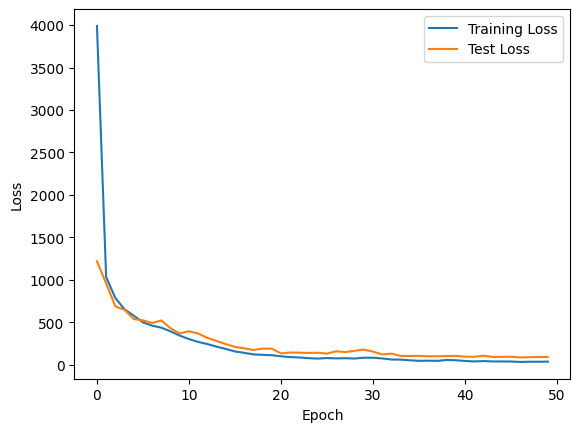

In [ ]:
# Step 6: Plot the training curves
plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
def save_checkpoint(state, filename="/content/drive/MyDrive/Colab Notebooks/model_50.pt"):
    torch.save(state, filename)

save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    })

NameError: name 'epoch' is not defined

Inference: [30.011138916015625, 98.28849029541016, 46.39103698730469, 86.23482513427734, 72.29073333740234, 88.35063934326172, 97.54049682617188, 93.67362976074219, 124.9964370727539, 101.8595962524414, 127.95446014404297, 185.62997436523438, 97.91864013671875, 192.71348571777344, 60.98640441894531, 184.8037109375]
True Values: [ 25.  95.  51.  90.  72.  94.  86.  95. 116. 101. 138. 184. 107. 195.
  67. 191.]


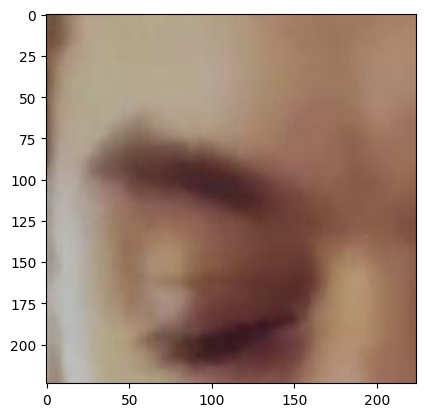

In [ ]:
# prompt: take an inference an image and show corresponding true value from the csv as well

# Load the image
image_path = '/content/data/images/color/2.jpg'
image = Image.open(image_path).convert('RGB')

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
image_tensor = transform(image).unsqueeze(0).to(device)

# Make prediction
model.eval()
with torch.no_grad():
    output = model(image_tensor)

# Get the true values from the csv file
df = pd.read_csv('/content/label.csv')
true_values = df.iloc[1, 1:].values.astype('float')

# Print the inference and true values
print(f'Inference: {output.squeeze().tolist()}')
print(f'True Values: {true_values}')

# Show the image
plt.imshow(image)
plt.show()


In [ ]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image

# Step 1: Unzip the image files
with zipfile.ZipFile('/content/color.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data/images')

# Step 2: Load and preprocess the data
class ImageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, str(self.data_frame.iloc[idx, 0]))
        image = Image.open(img_name).convert('RGB')
        labels = self.data_frame.iloc[idx, 1:].values.astype('float')

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(labels)

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load the dataset
dataset = ImageDataset(csv_file='/content/label.csv', root_dir='/content/data/images/color', transform=transform)

# Step 3: Split the data into training and testing sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Define the ResNet model
class ResNetRegressor(nn.Module):
    def __init__(self):
        super(ResNetRegressor, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Sequential(
            nn.Linear(self.resnet.fc.in_features, 512),
            nn.ReLU(),
            nn.Linear(512, 16)  # 16 output values
        )

    def forward(self, x):
        return self.resnet(x)


# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = ResNetRegressor().to(device).float()  # Move model to GPU and ensure model parameters are in float
criterion = nn.MSELoss().to(device).float()  # Move loss function to GPU and ensure it is in float
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Functions to save and load model checkpoints
def save_checkpoint(state, filename="/content/drive/MyDrive/Colab Notebooks/model_50.pt"):
    torch.save(state, filename)

def load_checkpoint(filename="/content/drive/MyDrive/Colab Notebooks/model_50.pt"):
    if os.path.isfile(filename):
        print(f"Loading checkpoint '{filename}'")
        checkpoint = torch.load(filename)

        # Check if the checkpoint contains a 'state_dict' key
        if 'state_dict' in checkpoint:
            model.load_state_dict(checkpoint['state_dict'])
        else:
            print("Checkpoint does not contain a 'state_dict' key.")

        # Check if the checkpoint contains an 'optimizer' key
        if 'optimizer' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer'])
        else:
            print("Checkpoint does not contain an 'optimizer' key.")

        return checkpoint['epoch']
    else:
        print(f"No checkpoint found at '{filename}'")
        return 0

# Add a callback to stop training if the test loss goes below 40
class EarlyStoppingCallback(object):
    def __init__(self, patience=3):
        self.patience = patience
        self.best_loss = None
        self.no_improvement_count = 0

    def __call__(self, epoch, test_loss):
        if self.best_loss is None or test_loss < self.best_loss:
            self.best_loss = test_loss
            self.no_improvement_count = 0
        else:
            self.no_improvement_count += 1
            if self.no_improvement_count >= self.patience:
                print(f"Early stopping at epoch {epoch+1}.")
                return True
        return False

early_stopping_callback = EarlyStoppingCallback(patience=3)

# Train the model with the early stopping callback
num_epochs = 120
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device).float(), labels.to(device).float()  # Move inputs and labels to GPU and ensure they are in float
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device).float(), labels.to(device).float()  # Move inputs and labels to GPU and ensure they are in float
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    test_losses.append(running_loss / len(test_loader))

    # Save the model checkpoint
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    })

    # Check if early stopping should be triggered
    if early_stopping_callback(epoch, test_losses[-1]):
        break

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}')


Using device: cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/120, Training Loss: 3982.7252, Test Loss: 1416.9675


KeyboardInterrupt: 

In [ ]:
# prompt: add a callback to above training so that the epoch stops if the test loss goes below 40

# Add a callback to stop training if the test loss goes below 40
class EarlyStoppingCallback(object):
    def __init__(self, patience=3):
        self.patience = patience
        self.best_loss = None
        self.no_improvement_count = 0

    def __call__(self, epoch, test_loss):
        if self.best_loss is None or test_loss < self.best_loss:
            self.best_loss = test_loss
            self.no_improvement_count = 0
        else:
            self.no_improvement_count += 1
            if self.no_improvement_count >= self.patience:
                print(f"Early stopping at epoch {epoch+1}.")
                return True
        return False

early_stopping_callback = EarlyStoppingCallback(patience=3)

# Train the model with the early stopping callback
num_epochs = 120
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device).float(), labels.to(device).float()  # Move inputs and labels to GPU and ensure they are in float
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device).float(), labels.to(device).float()  # Move inputs and labels to GPU and ensure they are in float
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    test_losses.append(running_loss / len(test_loader))

    # Save the model checkpoint
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    })

    # Check if early stopping should be triggered
    if early_stopping_callback(epoch, test_losses[-1]):
        break

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}')


Epoch 1/120, Training Loss: 22.9179, Test Loss: 49.5645


KeyboardInterrupt: 

In [ ]:
# prompt: download the current model

from google.colab import files

# Save the model to a file
save_checkpoint({
    'epoch': epoch + 1,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}, filename="/content/model.pt")

# Download the model file
files.download("/content/model.pt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Inference: [67.7896728515625, 185.60513305664062, 46.4532470703125, 99.6432876586914, 61.99232864379883, 95.80964660644531, 77.74703979492188, 99.98253631591797, 92.31424713134766, 106.09577178955078, 115.76458740234375, 116.06735229492188, 141.66421508789062, 193.81170654296875, 109.6345443725586, 200.7733612060547]
True Values: [ 66. 191.  38.  95.  54.  92.  73.  95.  91. 104. 110. 115. 134. 190.
 106. 198.]


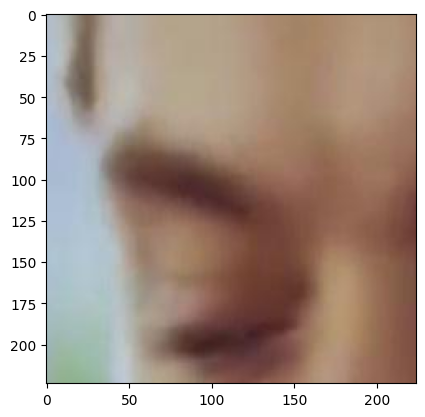

In [ ]:
# prompt: compare the result of an image, true vs predicted

# Load the image
image_path = '/content/data/images/color/123.jpg'
image = Image.open(image_path).convert('RGB')

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
image_tensor = transform(image).unsqueeze(0).to(device)

# Make prediction
model.eval()
with torch.no_grad():
    output = model(image_tensor)

# Get the true values from the csv file
df = pd.read_csv('/content/label.csv')
true_values = df.iloc[122, 1:].values.astype('float')

# Print the inference and true values
print(f'Inference: {output.squeeze().tolist()}')
print(f'True Values: {true_values}')

# Show the image
plt.imshow(image)
plt.show()
